In [1]:
import numpy as np
import pickle
import gc
from tqdm import tqdm
from loguru import logger
from sklearn import metrics
import matplotlib.pyplot as plt 
from source.utils.file_read import process_and_concat_files 
from source.utils.file_read import filter_df
from sklearn.utils.fixes import parse_version, sp_version
solver = "highs" if sp_version >= parse_version("1.6.0") else "interior-point"
from IPython.display import clear_output

In [2]:
from source.ensemble.stack_generalization.ramp_detection.boxplot_detector import detect_wind_ramp_boxplot
from source.ensemble.stack_generalization.ramp_detection.utils import append_wind_ramps, append_ramp_alarm_days
from source.ensemble.stack_generalization.ramp_detection.utils_plot import calculate_ramp_events, plot_ramp_confusion_matrix

In [3]:
from config.ramp_calib_setting import Simulation, WeightedAvg, Stack
from source.utils.session_ml_info import delete_previous_day_pickle
sim_params = Simulation.testing_period
weight_avg_params = WeightedAvg.params
ens_params = Stack.params

Testing Days: 100%|██████████| 300/300 [00:21<00:00, 13.73it/s]


Actual ramp events num: 12
Predicted ramp events num: 19
Total dates: 300
Critical Success Index (CSI): 0.07
Bias Score (BS): 1.73
F1 Score: 0.13
ROC AUC: 0.56


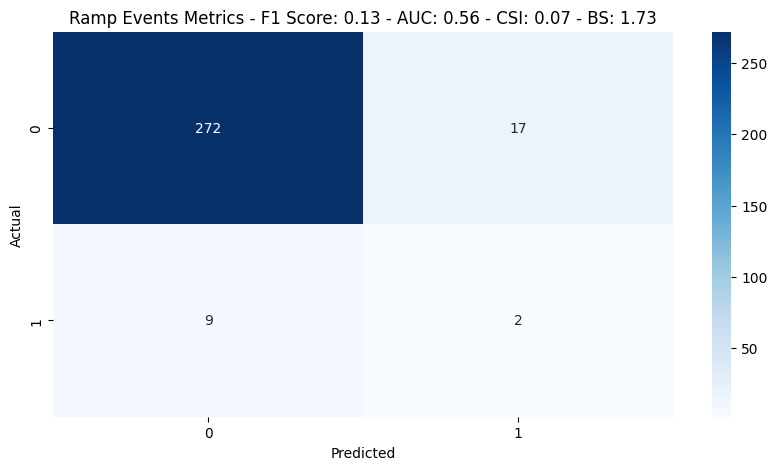

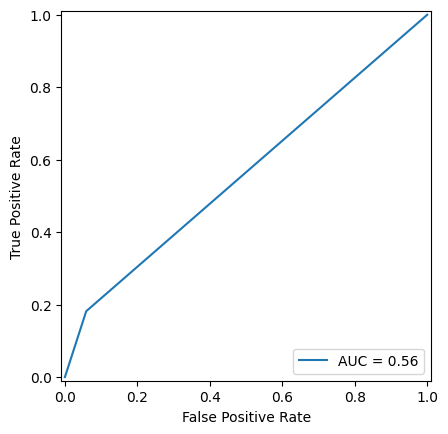

Actual ramp events num: 12
Predicted ramp events num: 40
Total dates: 900
Critical Success Index (CSI): 0.04
Bias Score (BS): 3.64
F1 Score: 0.08
ROC AUC: 0.57


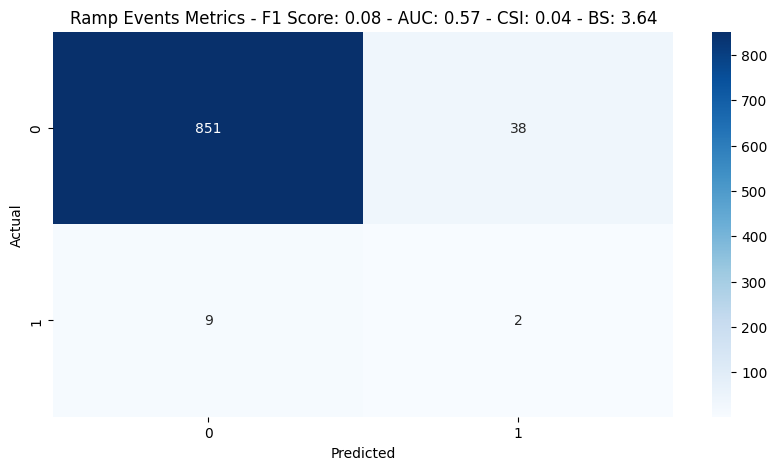

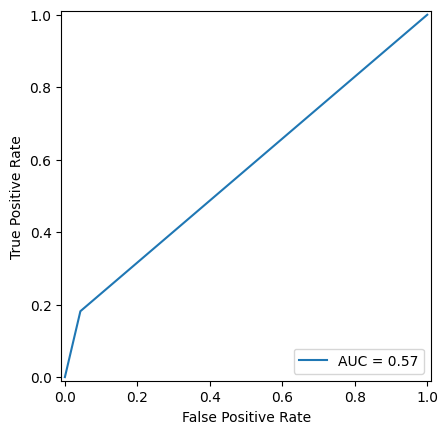

In [4]:
# set random seed
np.random.seed(sim_params['random_seed'])

# process and concatenate files
files = [sim_params['file_1'], sim_params['file_2'], sim_params['file_3'], sim_params['file_4'], 
            sim_params['file_5'], sim_params['file_6'], sim_params['file_7'], sim_params['file_8'], 
            sim_params['file_9'], sim_params['file_10'], sim_params['file_11'], sim_params['file_12']]

logger.info(' ')
logger.info(f'Load Files: {files}')

df = process_and_concat_files(files)

# filter data forecasters
df_filtered = filter_df(df, sim_params['forecasts_col'], sim_params['measured_col'])

# replace NaN values
if sim_params['replace_nan']:
    logger.info(' ')
    logger.warning("Replacing NaN values with 0s")
    print(df_filtered.isna().sum())
    df_filtered.fillna(0, inplace=True)

# set buyer resource name
buyer_resource_name = 'b1r1'

# remove previous day pickle file
logger.info(' ')
delete_previous_day_pickle()
logger.opt(colors = True).warning('previous day pickle file removed')

# loop over max_consecutive_points
for max_consecutive_points in [3]: # [3, 6, 9]:
    # loop over k values
    for k in [1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8]: 
        # lists to store f1 and roc auc scores for symmetric distribution
        list_f1_sym = []
        list_roc_auc_sym = []
        list_cis_sym = []
        list_bs_sym = []
        # lists to store f1 and roc auc scores for asymmetric distribution
        list_f1_asym = []
        list_roc_auc_asym = []
        list_cis_asym = []
        list_bs_asym = []
        # loop over q1 and q3 values
        for q1, q3 in [(0.3, 0.7), (0.5, 0.7), (0.275, 0.725), (0.5, 0.725),
                        (0.25, 0.75), (0.5, 0.75), (0.225, 0.775), (0.5, 0.775),
                        (0.2, 0.8), (0.5, 0.8)]:   
            # loop over preprocess_ramps
            for preprocess_ramps in [True]:

                # Collect Ramp Alarm
                list_ramp_alarm = []
                # Collect Ramp Alarm Intraday
                list_ramp_alarm_intraday = []
                # Days of Ramp Alarm
                list_ramp_alarm_days = []

                # Days of Wind Ramps
                lst_wind_ramps_days = []

                # load pickle file named 'results_pred_var.pkl'
                with open('/Users/gio/Desktop/Elia-RES-Forecasting/results_pred_var_no_mostrecent.pkl', 'rb') as f:
                    results_pred_var = pickle.load(f)

                # loop over test days
                for i in tqdm(range(len(results_pred_var)), desc='Testing Days'):

                    pred_var_insample = results_pred_var[i]['pred_var_in']
                    pred_var_outsample = results_pred_var[i]['pred_var_out']
                    target_variability = results_pred_var[i]['target_variability']
                    forecast_range = results_pred_var[i]['forecast_range']
                    df_train = results_pred_var[i]['df_train']

                    logger.info(' ')
                    logger.opt(colors = True).info(f'<blue>-------------------------------------------------------------------------------------------</blue>')
                    logger.opt(colors=True).info(f'<blue> Testing Day : {i}</blue>')
                    logger.opt(colors=True).info(f'<blue> k*IQR -> k : {k}</blue>')
                    logger.opt(colors=True).info(f'<blue> (Q1, Q3) : ({q1}, {q3})</blue>')
                    logger.opt(colors=True).info(f'<blue> Preprocess Ramps : {preprocess_ramps}</blue>')
                    logger.opt(colors = True).info(f'<blue>-------------------------------------------------------------------------------------------</blue>')

                    # # ----------------------------> RAMPS ALARM <----------------------------

                    # Detect Wind Ramp using Boxplot
                    list_ramp_alarm, list_ramp_alarm_intraday, alarm_status, upper_box_bound, df_ramp_clusters = detect_wind_ramp_boxplot(pred_insample = pred_var_insample, 
                                                                                                                                            pred_outsample = pred_var_outsample, 
                                                                                                                                            list_ramp_alarm=list_ramp_alarm,
                                                                                                                                            list_ramp_alarm_intraday=list_ramp_alarm_intraday,
                                                                                                                                            df_train=df_train, 
                                                                                                                                            q1=q1, q3=q3, 
                                                                                                                                            k=k, 
                                                                                                                                            preprocess_ramps=preprocess_ramps,
                                                                                                                                            max_consecutive_points=max_consecutive_points)
                    
                    # Append Wind Ramps Days
                    lst_wind_ramps_days = append_wind_ramps(df, list_ramp_alarm, i, target_variability, lst_wind_ramps_days, pred_var_outsample)

                    # Append Ramps Alarm Days
                    list_ramp_alarm_days = append_ramp_alarm_days(alarm_status, target_variability, pred_var_outsample, df_ramp_clusters, list_ramp_alarm_days)


                    # Clear Variables
                    del pred_var_insample, pred_var_outsample, target_variability, forecast_range, df_train
                    gc.collect()

                    # Clear output
                    clear_output(wait=True)


                # # ----------------------------> PLOT RAMPS ALARM <----------------------------

                # Calculate Ramp Events
                ramp_events_by_date, ramp_threshold = calculate_ramp_events(df, list_ramp_alarm, list_ramp_alarm_intraday, intraday=False)

                # F1-Score and Confusion Matrix
                f1_value, roc_auc_value, csi_value, bs_value, fpr, tpr = plot_ramp_confusion_matrix(ramp_events_by_date)
                plt.show()

                # Plotting the ROC Curve
                display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_value)
                display.plot()
                plt.show()

                # Calculate Ramp Events Intraday
                intraday = True
                ramp_events_by_intraday, _ = calculate_ramp_events(df, list_ramp_alarm, list_ramp_alarm_intraday, intraday=intraday)

                # F1-Score and Confusion Matrix
                f1_value_intraday, roc_auc_value_intraday, csi_value_intraday, bs_value_intraday, fpr_intraday, tpr_intraday = plot_ramp_confusion_matrix(ramp_events_by_intraday)
                plt.show()

                # Plotting the ROC Curve
                display_intraday = metrics.RocCurveDisplay(fpr=fpr_intraday, tpr=tpr_intraday, roc_auc=roc_auc_value_intraday)
                display_intraday.plot()
                plt.show()

                # Append F1 Score to list
                if q1 != 0.5:  # Symmetric Distribution
                    list_f1_sym.append({ "q3_q1" : (q3, q1),
                                                "k" : k,
                                                # day-ahead
                                                "FPR": fpr, 
                                                "TPR": tpr,
                                                "f1" : f1_value,
                                                'alarms_days': list_ramp_alarm_days,
                                                "ramp_events_by_date":ramp_events_by_date,
                                                # intraday-ahead
                                                "FPR_intraday": fpr_intraday,
                                                "TPR_intraday": tpr_intraday,
                                                "f1_intraday" : f1_value_intraday,
                                                'alarms_days_intraday': list_ramp_alarm_intraday,
                                                "ramp_events_by_intraday":ramp_events_by_intraday,
                                                # wind ramps
                                                "lst_wind_ramps_days": lst_wind_ramps_days,
                                                'ramp_threshold':ramp_threshold})
                else:  # Asymmetric Distribution
                    list_f1_asym.append({ "q3_q1" : (q3, q1),
                                                "k" : k,
                                                # day-ahead
                                                "FPR": fpr, 
                                                "TPR": tpr,
                                                "f1" : f1_value,
                                                'alarms_days': list_ramp_alarm_days,
                                                "ramp_events_by_date":ramp_events_by_date,
                                                # intraday-ahead
                                                "FPR_intraday": fpr_intraday,
                                                "TPR_intraday": tpr_intraday,
                                                "f1_intraday" : f1_value_intraday,
                                                'alarms_days_intraday': list_ramp_alarm_intraday,
                                                "ramp_events_by_intraday":ramp_events_by_intraday,
                                                # wind ramps
                                                "lst_wind_ramps_days": lst_wind_ramps_days,
                                                'ramp_threshold':ramp_threshold})
                    
                
                # Append ROC AUC Score to list
                if q1 != 0.5:  # Symmetric Distribution
                    list_roc_auc_sym.append({"q3_q1" : (q3, q1),
                                                    "k" : k,
                                                    # day-ahead
                                                    "FPR": fpr, 
                                                    "TPR": tpr,
                                                    "roc_auc" : roc_auc_value,
                                                    'alarms_days': list_ramp_alarm_days,
                                                    "ramp_events_by_date":ramp_events_by_date,
                                                    # intraday-ahead
                                                    "FPR_intraday": fpr_intraday,
                                                    "TPR_intraday": tpr_intraday,
                                                    "roc_auc_intraday" : roc_auc_value_intraday,
                                                    'alarms_days_intraday': list_ramp_alarm_intraday,
                                                    "ramp_events_by_intraday":ramp_events_by_intraday,
                                                    # wind ramps
                                                    "lst_wind_ramps_days": lst_wind_ramps_days,
                                                    'ramp_threshold':ramp_threshold})
                    
                else:  # Asymmetric Distribution
                    list_roc_auc_asym.append({"q3_q1" : (q3, q1),
                                                    "k" : k,
                                                    # day-ahead
                                                    "FPR": fpr, 
                                                    "TPR": tpr,
                                                    "roc_auc" : roc_auc_value,
                                                    'alarms_days': list_ramp_alarm_days,
                                                    "ramp_events_by_date":ramp_events_by_date,
                                                    # intraday-ahead
                                                    "FPR_intraday": fpr_intraday,
                                                    "TPR_intraday": tpr_intraday,
                                                    "roc_auc_intraday" : roc_auc_value_intraday,
                                                    'alarms_days_intraday': list_ramp_alarm_intraday,
                                                    "ramp_events_by_intraday":ramp_events_by_intraday,
                                                    # wind ramps
                                                    "lst_wind_ramps_days": lst_wind_ramps_days,
                                                    'ramp_threshold':ramp_threshold})
                    
                if q1 != 0.5:
                    list_cis_sym.append({"q3_q1" : (q3, q1),
                                        "k" : k,
                                        #day-ahead
                                        "FPR": fpr,
                                        "TPR": tpr,
                                        "csi" : csi_value,
                                        "alarms_days": list_ramp_alarm_days,
                                        "ramp_events_by_date":ramp_events_by_date,
                                        #intraday-ahead
                                        "FPR_intraday": fpr_intraday,
                                        "TPR_intraday": tpr_intraday,
                                        "csi_intraday" : csi_value_intraday,
                                        "alarms_days_intraday": list_ramp_alarm_intraday,
                                        "ramp_events_by_intraday":ramp_events_by_intraday,
                                        #wind ramps
                                        "lst_wind_ramps_days": lst_wind_ramps_days,
                                        'ramp_threshold':ramp_threshold})
                else:
                    list_cis_asym.append({"q3_q1" : (q3, q1),
                                        "k" : k,
                                        #day-ahead
                                        "FPR": fpr,
                                        "TPR": tpr,
                                        "csi" : csi_value,
                                        "alarms_days": list_ramp_alarm_days,
                                        "ramp_events_by_date":ramp_events_by_date,
                                        #intraday-ahead
                                        "FPR_intraday": fpr_intraday,
                                        "TPR_intraday": tpr_intraday,
                                        "csi_intraday" : csi_value_intraday,
                                        "alarms_days_intraday": list_ramp_alarm_intraday,
                                        "ramp_events_by_intraday":ramp_events_by_intraday,
                                        #wind ramps
                                        "lst_wind_ramps_days": lst_wind_ramps_days,
                                        'ramp_threshold':ramp_threshold})
                    
                if q1 != 0.5:
                    list_bs_sym.append({"q3_q1" : (q3, q1),
                                        "k": k,
                                        #day-ahead
                                        "FPR": fpr,
                                        "TPR": tpr,
                                        "bs" : bs_value,
                                        "alarms_days": list_ramp_alarm_days,
                                        "ramp_events_by_date":ramp_events_by_date,
                                        #intraday-ahead
                                        "FPR_intraday": fpr_intraday,
                                        "TPR_intraday": tpr_intraday,
                                        "bs_intraday" : bs_value_intraday,
                                        "alarms_days_intraday": list_ramp_alarm_intraday,
                                        "ramp_events_by_intraday":ramp_events_by_intraday,
                                        #wind ramps
                                        "lst_wind_ramps_days": lst_wind_ramps_days,
                                        'ramp_threshold':ramp_threshold})
                else:
                    list_bs_asym.append({"q3_q1" : (q3, q1),
                                        "k": k,
                                        #day-ahead
                                        "FPR": fpr,
                                        "TPR": tpr,
                                        "bs" : bs_value,
                                        "alarms_days": list_ramp_alarm_days,
                                        "ramp_events_by_date":ramp_events_by_date,
                                        #intraday-ahead
                                        "FPR_intraday": fpr_intraday,
                                        "TPR_intraday": tpr_intraday,
                                        "bs_intraday" : bs_value_intraday,
                                        "alarms_days_intraday": list_ramp_alarm_intraday,
                                        "ramp_events_by_intraday":ramp_events_by_intraday,
                                        #wind ramps
                                        "lst_wind_ramps_days": lst_wind_ramps_days,
                                        'ramp_threshold':ramp_threshold})

                # import time
                # time.sleep(25)

                # Clear output
                clear_output(wait=True)

        # ----------------------------> SAVE RESULTS <----------------------------

        if len(list_f1_sym) != 0:
            # save file
            with open(f'results/box/{max_consecutive_points}_consecutive_no_mostrecent/{max_consecutive_points}_{k}_f1_symmetric.pkl', 'wb') as f:
                pickle.dump(list_f1_sym, f)

        if len(list_f1_asym) != 0:
            # save file
            with open(f'results/box/{max_consecutive_points}_consecutive_no_mostrecent/{max_consecutive_points}_{k}_f1_asymmetric.pkl', 'wb') as f:
                pickle.dump(list_f1_asym, f)

        if len(list_roc_auc_asym) != 0:
            # save file
            with open(f'results/box/{max_consecutive_points}_consecutive_no_mostrecent/{max_consecutive_points}_{k}_roc_auc_asymmetric.pkl', 'wb') as f:
                pickle.dump(list_roc_auc_asym, f)

        if len(list_roc_auc_sym) != 0:
            # save file
            with open(f'results/box/{max_consecutive_points}_consecutive_no_mostrecent/{max_consecutive_points}_{k}_roc_auc_symmetric.pkl', 'wb') as f:
                pickle.dump(list_roc_auc_sym, f)

        if len(list_cis_sym) != 0:
            # save file
            with open(f'results/box/{max_consecutive_points}_consecutive_no_mostrecent/{max_consecutive_points}_{k}_csi_symmetric.pkl', 'wb') as f:
                pickle.dump(list_cis_sym, f)

        if len(list_cis_asym) != 0:
            # save file
            with open(f'results/box/{max_consecutive_points}_consecutive_no_mostrecent/{max_consecutive_points}_{k}_csi_asymmetric.pkl', 'wb') as f:
                pickle.dump(list_cis_asym, f)

        if len(list_bs_sym) != 0:
            # save file
            with open(f'results/box/{max_consecutive_points}_consecutive_no_mostrecent/{max_consecutive_points}_{k}_bs_symmetric.pkl', 'wb') as f:
                pickle.dump(list_bs_sym, f)
        
        if len(list_bs_asym) != 0:
            # save file
            with open(f'results/box/{max_consecutive_points}_consecutive_no_mostrecent/{max_consecutive_points}_{k}_bs_asymmetric.pkl', 'wb') as f:
                pickle.dump(list_bs_asym, f)
        
